In [325]:
#!pip install pandas_profiling

In [326]:
## EDA & visualization
import pandas as pd
from pandas_profiling import ProfileReport
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## preprocessing, regression & bulding pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, KFold  #StratifiedKFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, KBinsDiscretizer #StandardScaler
from sklearn.preprocessing import OrdinalEncoder, PolynomialFeatures, FunctionTransformer
from sklearn.metrics import mean_squared_log_error

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.pipeline import Pipeline, make_pipeline

## Data

In [327]:
train = pd.read_csv("../data/train.csv", index_col=0, parse_dates=True)
test = pd.read_csv("../data/test.csv", index_col=0, parse_dates=True)
df = train.copy(deep=True)

## Exploratory Data Analysis & Feature Engineering

In [328]:
profile = ProfileReport(df, title="Pandas Profiling Report")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

<AxesSubplot:xlabel='datetime'>

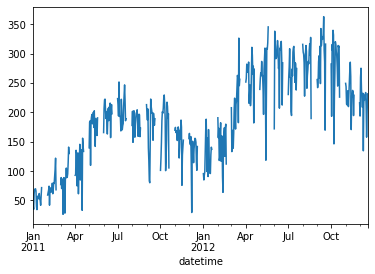

In [329]:
df.resample('D')['count'].mean().plot()

###### We can see a clear anual seasonality pattern as well as an upward trend within the years.

<AxesSubplot:xlabel='datetime'>

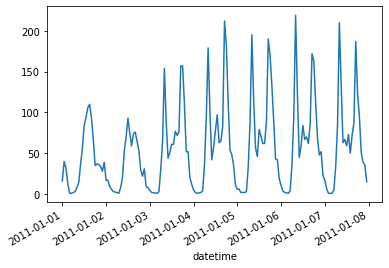

In [330]:
df.loc["2011-01-01":"2011-01-07"]["count"].plot()

In [331]:
def add_time_features(df):
    df["year"] = df.index.year
    df["month"] = df.index.month
    df["week"] = df.index.week
    df["day"] = df.index.day
    df["hour"] = df.index.hour

    df["DayOfWeek"] = df.index.dayofweek

# cyclicle features
    # daily
    df["hour_sin"] = np.sin(2 * np.pi * df["hour"] /24)
    df["hour_cos"] = np.cos(2 * np.pi * df["hour"] /24)
    # month
    df["month_sin"] = np.sin(2 * np.pi * df["month"] /12)
    df["month_cos"] = np.cos(2 * np.pi * df["month"] /12)

# categorical features
    df["rushhour"] = 0
    df.loc[(df.workingday == 1) & (df.hour >= 7)&(df.hour <= 9), "rushhour"] = 1
    df.loc[(df.workingday == 1) & (df.hour >= 17)&(df.hour <= 19), "rushhour"] = 1

    df["daynight"] = np.NaN
    df.loc[(df.hour <= 19)&(df.hour >= 7), "daynight"] = "day"    # day
    df.loc[(df.hour <= 6)|(df.hour >= 20), "daynight"] = "night"    # night
    
    return df

In [332]:
add_time_features(df)
df.head(4)#

c:\Users\power\anaconda3\envs\your_project_name\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  after removing the cwd from sys.path.


season  holiday  workingday  weather  temp   atemp  \
datetime                                                                  
2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
2011-01-01 01:00:00       1        0           0        1  9.02  13.635   
2011-01-01 02:00:00       1        0           0        1  9.02  13.635   
2011-01-01 03:00:00       1        0           0        1  9.84  14.395   

                     humidity  windspeed  casual  registered  ...  week  day  \
datetime                                                      ...              
2011-01-01 00:00:00        81        0.0       3          13  ...    52    1   
2011-01-01 01:00:00        80        0.0       8          32  ...    52    1   
2011-01-01 02:00:00        80        0.0       5          27  ...    52    1   
2011-01-01 03:00:00        75        0.0       3          10  ...    52    1   

                     hour  DayOfWeek  hour_sin  hour_cos  month_sin  \
datetime                                                              
2011-01-01 00:00:00     0          5  0.000000  1.000000        0.5   
2011-01-01 01:00:00     1          5  0.258819  0.965926        0.5   
2011-01-01 02:00:00     2          5  0.500000  0.866025        0.5   
2011-01-01 03:00:00     3          5  0.707107  0.707107        0.5   

                     month_cos  rushhour  daynight  
datetime                                            
2011-01-01 00:00:00   0.866025         0     night  
2011-01-01 01:00:00   0.866025         0     night  
2011-01-01 02:00:00   0.866025         0     night  
2011-01-01 03:00:00   0.866025         0     night  

[4 rows x 23 columns]

In [333]:
def get_graph(df, fig_name, y="count"):

    fig, axes = plt.subplots(nrows=2, ncols=2)
    fig.set_size_inches(30,15)
    dow_labels = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
    mon_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'Mai', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

    sns.barplot(data = df, x="year", y=y, ax = axes[0,0])
    sns.barplot(data = df, x="month", y=y, ax = axes[0,1]).set_xticklabels(mon_labels)
    sns.pointplot(data = df, x="hour", y=y, ax = axes[1,0], hue = "DayOfWeek")
    sns.pointplot(data = df, x="DayOfWeek", y=y, ax = axes[1,1], hue = "year").set_xticklabels(dow_labels)
    fig.savefig(fig_name)
    fig.show()

c:\Users\power\anaconda3\envs\your_project_name\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


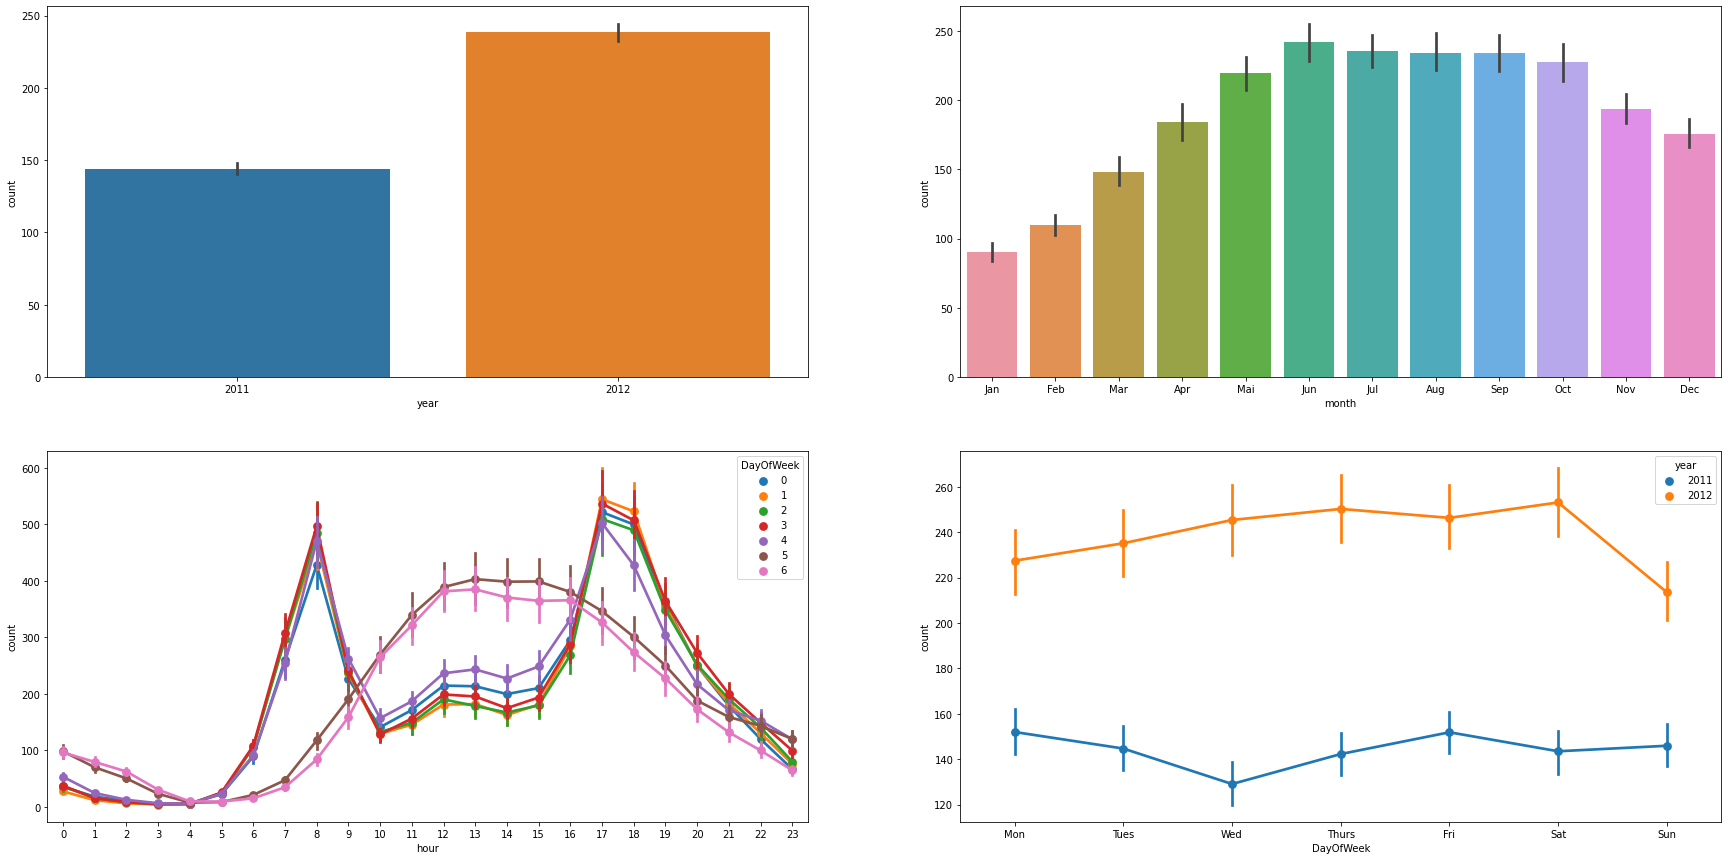

In [334]:
get_graph(df, "eda_plots")

c:\Users\power\anaconda3\envs\your_project_name\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]
c:\Users\power\anaconda3\envs\your_project_name\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


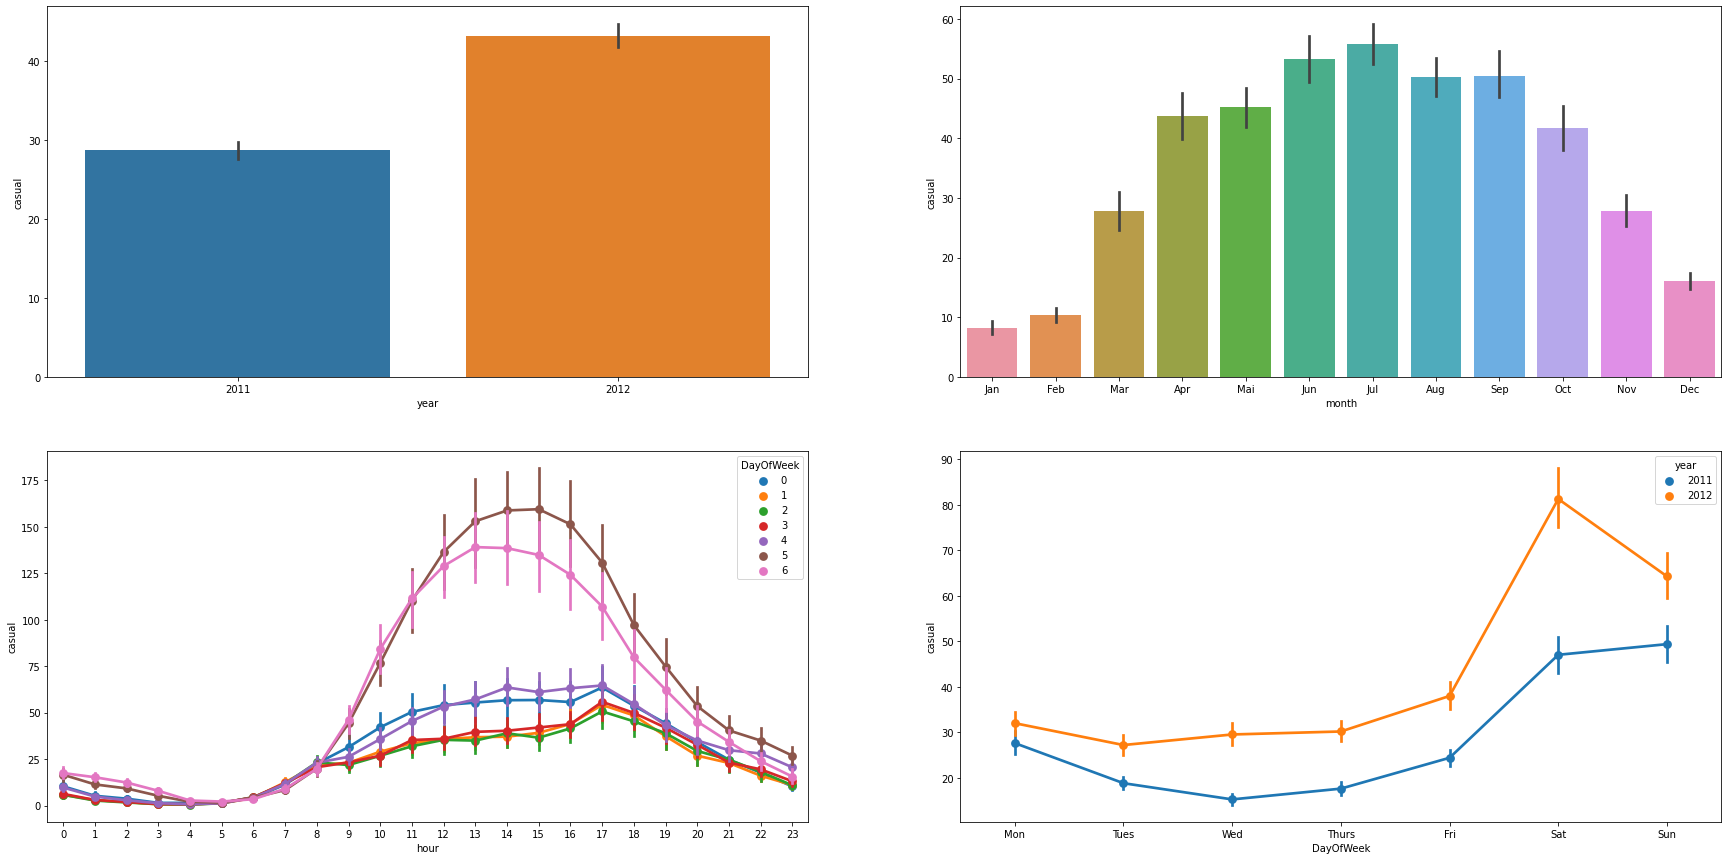

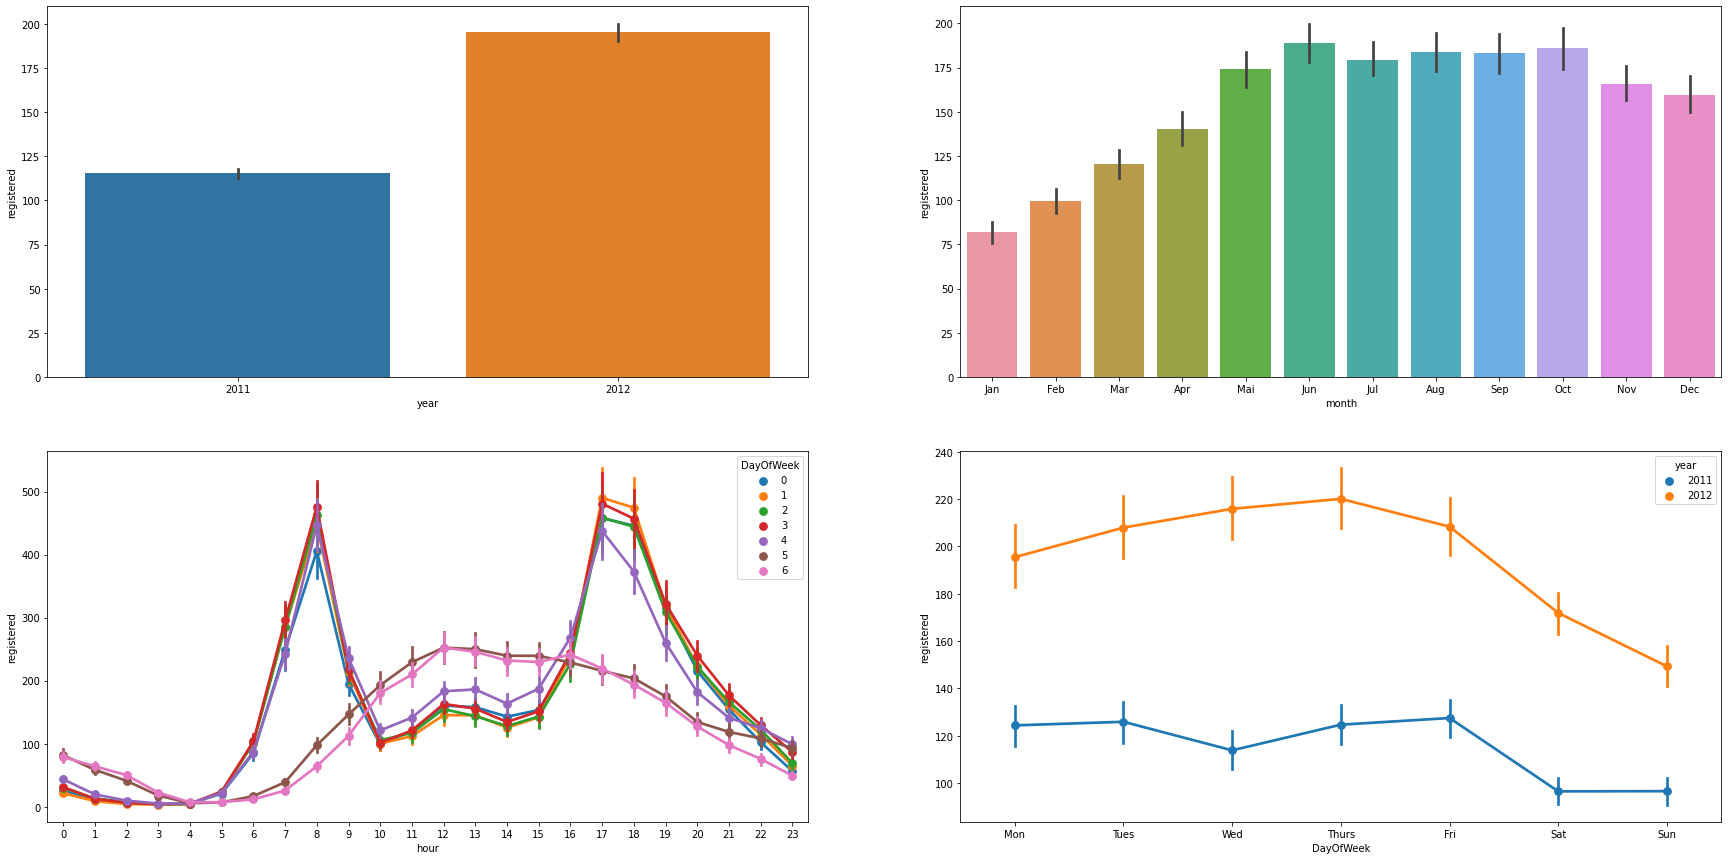

In [335]:
get_graph(df, "eda_casual_graph", y="casual")
get_graph(df, "eda_registered_graph", y="registered")

***Casual bike renters*** 
- use the bikes from 7am increasingly throughout the day with peak times between 2-5 pm, declining until midnight. 
- They use them throughout the whole week, but especially on the weekend
- There is a seasonal preference to rend the bikes, from april to october.
- In 2012 the demand increased compared to the year before.

***Registered bike renters*** 
- use the bikes from 6am throughout the day with two peak times. In the morning from 7-8 am and in the afternoon from 5-6 pm. 
- The demand is similar throughout the whole week 
- The bikes are used throughout the year, mostly though in the months from mai till december.
- In 2012 the demand increased compared to the year before. 

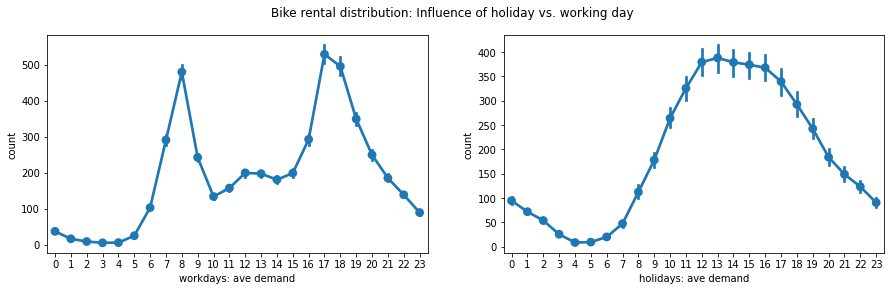

In [336]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(15,4)

weekday_df = df[df['workingday'] == 1]
holiday_df = df[df['workingday'] == 0]

sns.pointplot(data = weekday_df, x="hour", y="count", ax = axes[0])
sns.pointplot(data = holiday_df, x="hour", y="count", ax = axes[1])
plt.suptitle('Bike rental distribution: Influence of holiday vs. working day')
axes[0].set_xlabel("workdays: ave demand")
axes[1].set_xlabel("holidays: ave demand")

fig.savefig("Bike_rental_distribution_holiday_working_day.png")

- on holidays the bike demand ist peaking 12am to 4pm for all of the users.

summary
- DAILY: during the week there are two peaks of bike demand, one in the morning and one in the afternoon. on weekend the bikes are mainly used during the day, with a peak in noon/early afternoon. On holidays there is only one peak of bike demand during the day, similar to the weekend distribution. 
- MONTHLY: During the year the bike demand in the individual months is slightly different between registered users and casual users. The first use the bikes all year around, mainly from mai till december, the latter use the bikes far less (lower toal number), but mainly from april till october.
- YEARLY: There is an inrease in demand visible from 2011 to 2012

<AxesSubplot:>

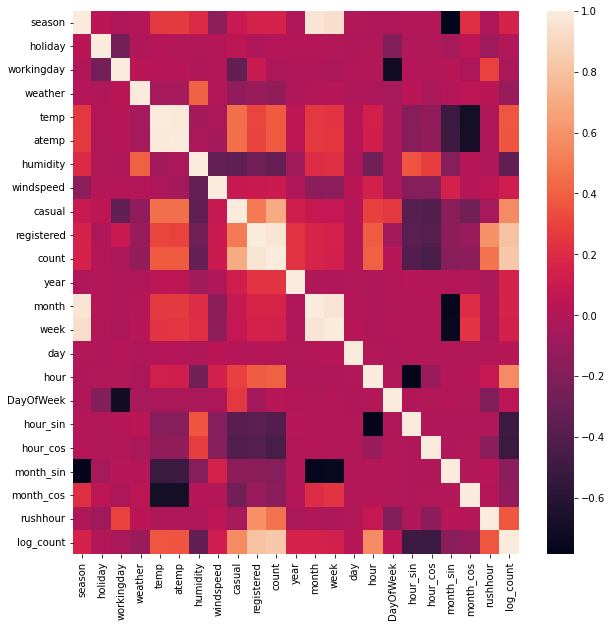

In [383]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr())

# Preprocessing the data

### Remove skewness of data (target variable)

c:\Users\power\anaconda3\envs\your_project_name\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\power\anaconda3\envs\your_project_name\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='count', ylabel='Density'>

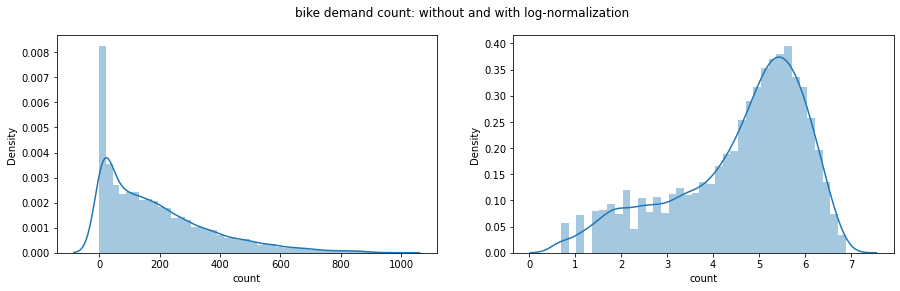

In [338]:
# data is presenting a left skew
# to remove the skewness, apply log'

fig, axes = plt.subplots(1, 2)
fig.set_size_inches(15,4)
plt.suptitle('bike demand count: without and with log-normalization')

sns.distplot(df["count"], ax = axes[0])
sns.distplot(np.log1p(df["count"]), ax = axes[1])


### Remove the outliers (that have a residual < stdev*3)

c:\Users\power\anaconda3\envs\your_project_name\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
c:\Users\power\anaconda3\envs\your_project_name\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='count'>

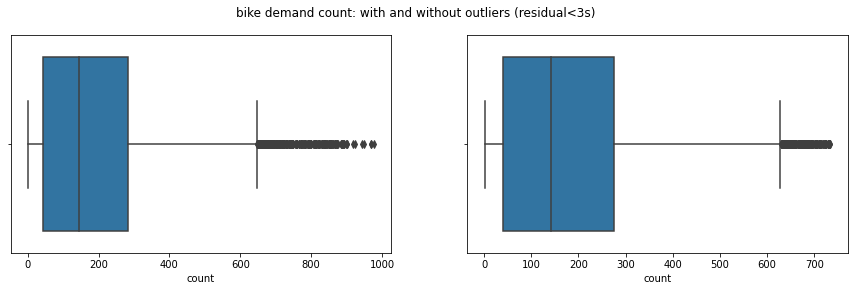

In [339]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(15,4)
plt.suptitle('bike demand count: with and without outliers (residual<3s)')

sns.boxplot(df["count"], ax = axes[0])
dfx = df[np.abs(df["count"])-df["count"].mean()<=(3*df["count"].std())]
sns.boxplot(dfx["count"], ax = axes[1])

In [340]:
def preprocessing(df):
    # remove skewness from data
    df["log_count"] = np.log1p(df["count"])
    # remove outliers that have a residual of <3sigma
    df = df[np.abs(df["count"])-df["count"].mean()<=(3*df["count"].std())]

    return df

In [341]:
df = preprocessing(df)

# Feature engineering

In [342]:
df.columns

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'casual', 'registered', 'count', 'year',
       'month', 'week', 'day', 'hour', 'DayOfWeek', 'hour_sin', 'hour_cos',
       'month_sin', 'month_cos', 'rushhour', 'daynight', 'log_count'],
      dtype='object')

In [343]:
X = df.drop(['count', 'log_count', 'casual', 'registered', 'DayofWeek'], axis=1)
y = df['log_count']

# y_log = np.log1p(y)

## Defining transformers and features

In [344]:
# numerical features
num_tr = MinMaxScaler()
num_fe = ["weather", "temp", "atemp", "humidity", "windspeed"]

# categorical features
## cat_tr = KBinsDiscretizer(n_bins=12, encode='onehot')
cat_tr = OneHotEncoder(drop="first")
cat_fe = ["season", "holiday", "workingday", "rushhour", "daynight", "DayOfWeek"]

In [345]:
#Creating column Transformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_tr, num_fe),
        ("cat", cat_tr, cat_fe)
    ], 
    remainder="passthrough")

### Linear Regression Model

In [346]:
pipeline_lin = make_pipeline(preprocessor, LinearRegression())
pipeline_lin.fit(X, y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', MinMaxScaler(),
                                                  ['weather', 'temp', 'atemp',
                                                   'humidity', 'windspeed']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['season', 'holiday',
                                                   'workingday', 'rushhour',
                                                   'daynight',
                                                   'DayOfWeek'])])),
                ('linearregression', LinearRegression())])

In [347]:
cross_val_score(pipeline_lin, X, y, scoring='r2', cv=KFold(n_splits=5, shuffle=True))

array([0.7532559 , 0.75705867, 0.76862465, 0.76487098, 0.76608376])

In [348]:
pipeline_lin.score(X, y)

0.7632924551432441

In [349]:
ypred_log1 = np.exp(pipeline_lin.predict(X))-1
ypred_log1 = pd.DataFrame(ypred_log1, index = df.index, columns=["predicted"])
ypred_log1

predicted
datetime                       
2011-01-01 00:00:00    5.965523
2011-01-01 01:00:00    5.522477
2011-01-01 02:00:00    5.636825
2011-01-01 03:00:00    6.419015
2011-01-01 04:00:00    7.685308
...                         ...
2012-12-19 19:00:00  712.425967
2012-12-19 20:00:00  166.978682
2012-12-19 21:00:00  129.445027
2012-12-19 22:00:00  114.989947
2012-12-19 23:00:00   94.067410

[10739 rows x 1 columns]

In [350]:
np.sqrt(mean_squared_log_error(np.exp(y), ypred_log1))

0.6506993781016477

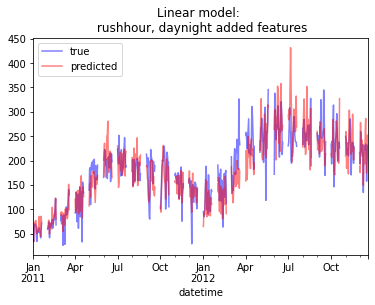

In [351]:
ax = df['count'].resample('D').mean().plot(c='b', alpha=0.5, label='true')
ypred_log1.resample('D').mean().plot(c='r', alpha=0.5, ax=ax, label='predicted')

ax.set_title('Linear model: \n rushhour, daynight added features')
plt.legend()

plt.savefig("LinearRegressionModel_true_pred")

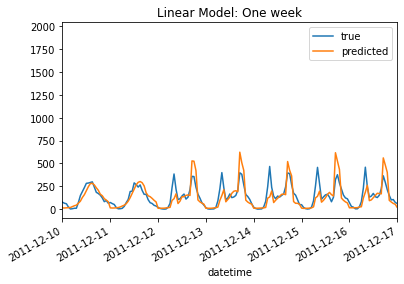

In [352]:
ax = df['count'].plot(label='true')
ypred_log1.plot(ax=ax)

plt.xlim(('2011-12-10 00:00:00', '2011-12-17 00:00:00'))
plt.title('Linear Model: One week')
plt.legend()

plt.savefig("LinearRegressionModel_true_pred_oneweek")

### Linear Regression Model + Polynomial Features

In [353]:
poly = PolynomialFeatures(degree=2, include_bias=False)

pipeline_lin_poly = make_pipeline(preprocessor, poly, LinearRegression())
pipeline_lin_poly.fit(X, y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', MinMaxScaler(),
                                                  ['weather', 'temp', 'atemp',
                                                   'humidity', 'windspeed']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['season', 'holiday',
                                                   'workingday', 'rushhour',
                                                   'daynight',
                                                   'DayOfWeek'])])),
                ('polynomialfeatures', PolynomialFeatures(include_bias=False)),
                ('linearregression', LinearRegression())])

In [354]:
cross_val_score(pipeline_lin_poly, X, y, scoring='r2', cv=KFold(n_splits=5, shuffle=True))

array([0.92405441, 0.92043169, 0.92963221, 0.92315019, 0.92205502])

In [355]:
pipeline_lin_poly.score(X,y)

0.9294539991136941

In [356]:
ypred_log1_lp = np.exp(pipeline_lin_poly.predict(X))-1
ypred_log1_lp = pd.DataFrame(ypred_log1, index = df.index, columns=["predicted"])
ypred_log1_lp

predicted
datetime                       
2011-01-01 00:00:00    5.965523
2011-01-01 01:00:00    5.522477
2011-01-01 02:00:00    5.636825
2011-01-01 03:00:00    6.419015
2011-01-01 04:00:00    7.685308
...                         ...
2012-12-19 19:00:00  712.425967
2012-12-19 20:00:00  166.978682
2012-12-19 21:00:00  129.445027
2012-12-19 22:00:00  114.989947
2012-12-19 23:00:00   94.067410

[10739 rows x 1 columns]

In [357]:
np.sqrt(mean_squared_log_error(np.exp(y), ypred_log1_lp))

0.6506993781016477

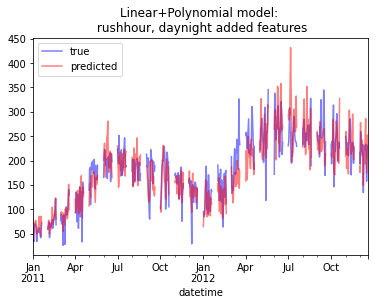

In [358]:
ax = df['count'].resample('D').mean().plot(c='b', alpha=0.5, label='true')
ypred_log1_lp.resample('D').mean().plot(c='r', alpha=0.5, ax=ax, label='predicted')

ax.set_title('Linear+Polynomial model: \n rushhour, daynight added features')
plt.legend()

plt.savefig("LinearRegression_Polynomial_Model_true_pred")

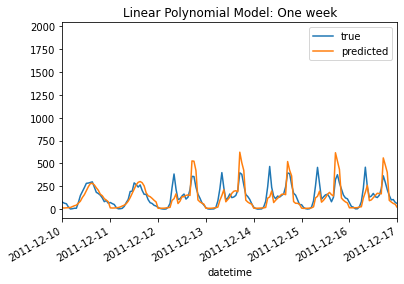

In [359]:
ax = df['count'].plot(label='true')
ypred_log1_lp.plot(ax=ax)

plt.xlim(('2011-12-10 00:00:00', '2011-12-17 00:00:00'))
plt.title('Linear Polynomial Model: One week')
plt.legend()

plt.savefig("LinearRegression_Polynomial_Model_true_pred_oneweek")

### Random Forest Regression Model

In [480]:
pipeline_rf = make_pipeline(preprocessor, RandomForestRegressor(max_depth=15, n_estimators=100))
pipeline_rf.fit(X, y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', MinMaxScaler(),
                                                  ['weather', 'temp', 'atemp',
                                                   'humidity', 'windspeed']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['season', 'holiday',
                                                   'workingday', 'rushhour',
                                                   'daynight',
                                                   'DayOfWeek'])])),
                ('randomforestregressor', RandomForestRegressor(max_depth=15))])

In [481]:
pipeline_rf_poly = make_pipeline(preprocessor, poly, RandomForestRegressor(max_depth=5, n_estimators=50))
pipeline_rf_poly.fit(X, y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', MinMaxScaler(),
                                                  ['weather', 'temp', 'atemp',
                                                   'humidity', 'windspeed']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['season', 'holiday',
                                                   'workingday', 'rushhour',
                                                   'daynight',
                                                   'DayOfWeek'])])),
                ('polynomialfeatures', PolynomialFeatures(include_bias=False)),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=5, n_estimators=50))])

In [482]:
print(cross_val_score(pipeline_rf, X, y, scoring='r2', cv=KFold(n_splits=5, shuffle=True)))
#print(cross_val_score(pipeline_rf_poly, X, y, scoring='r2', cv=KFold(n_splits=5, shuffle=True)))

[0.95547809 0.95910837 0.95040211 0.95090678 0.95164099]


In [483]:
print(pipeline_rf.score(X,y))
print(pipeline_rf_poly.score(X,y))

0.9907258310456014
0.8818097322218073


In [498]:
ypred_log1_rf = np.exp(pipeline_lin_poly.predict(X))-1
ypred_log1_rf = pd.DataFrame(ypred_log1, index = df.index, columns=["predicted"])

# ypred_log1_rfp = np.exp(pipeline_lin_poly.predict(X))-1
# ypred_log1_rfp = pd.DataFrame(ypred_log1, index = df.index, columns=["predicted"])

In [499]:
print(np.sqrt(mean_squared_log_error(np.exp(y), ypred_log1_rf)))
#print(np.sqrt(mean_squared_log_error(np.exp(y), ypred_log1_rfp)))

0.6506993781016477


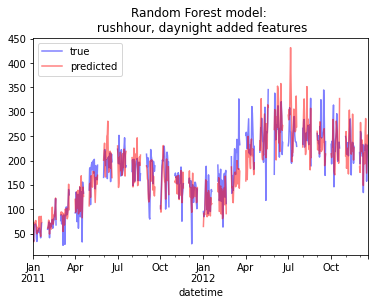

In [500]:
ax = df['count'].resample('D').mean().plot(c='b', alpha=0.5, label='true')
ypred_log1_rf.resample('D').mean().plot(c='r', alpha=0.5, ax=ax, label='predicted')

ax.set_title('Random Forest model: \n rushhour, daynight added features')
plt.legend()

plt.savefig("RandomForest_Model_true_pred")

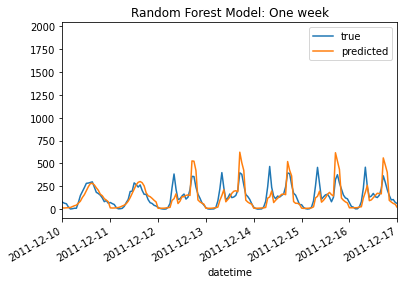

In [501]:
ax = df['count'].plot(label='true')
ypred_log1_rf.plot(ax=ax)

plt.xlim(('2011-12-10 00:00:00', '2011-12-17 00:00:00'))
plt.title('Random Forest Model: One week')
plt.legend()

plt.savefig("RandomForest_Model_true_pred_oneweek")

# Predicting test results

In [502]:
test.head(2)

season  holiday  workingday  weather   temp   atemp  \
datetime                                                                   
2011-01-20 00:00:00       1        0           1        1  10.66  11.365   
2011-01-20 01:00:00       1        0           1        1  10.66  13.635   

                     humidity  windspeed  year  month  week  day  hour  \
datetime                                                                 
2011-01-20 00:00:00        56    26.0027  2011      1     3   20     0   
2011-01-20 01:00:00        56     0.0000  2011      1     3   20     1   

                     DayOfWeek  hour_sin  hour_cos  month_sin  month_cos  \
datetime                                                                   
2011-01-20 00:00:00          3  0.000000  1.000000        0.5   0.866025   
2011-01-20 01:00:00          3  0.258819  0.965926        0.5   0.866025   

                     rushhour daynight  
datetime                                
2011-01-20 00:00:00         0    night  
2011-01-20 01:00:00         0    night

In [503]:
X_test = add_time_features(test)
X_test.head(3)

c:\Users\power\anaconda3\envs\your_project_name\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  after removing the cwd from sys.path.


season  holiday  workingday  weather   temp   atemp  \
datetime                                                                   
2011-01-20 00:00:00       1        0           1        1  10.66  11.365   
2011-01-20 01:00:00       1        0           1        1  10.66  13.635   
2011-01-20 02:00:00       1        0           1        1  10.66  13.635   

                     humidity  windspeed  year  month  week  day  hour  \
datetime                                                                 
2011-01-20 00:00:00        56    26.0027  2011      1     3   20     0   
2011-01-20 01:00:00        56     0.0000  2011      1     3   20     1   
2011-01-20 02:00:00        56     0.0000  2011      1     3   20     2   

                     DayOfWeek  hour_sin  hour_cos  month_sin  month_cos  \
datetime                                                                   
2011-01-20 00:00:00          3  0.000000  1.000000        0.5   0.866025   
2011-01-20 01:00:00          3  0.258819  0.965926        0.5   0.866025   
2011-01-20 02:00:00          3  0.500000  0.866025        0.5   0.866025   

                     rushhour daynight  
datetime                                
2011-01-20 00:00:00         0    night  
2011-01-20 01:00:00         0    night  
2011-01-20 02:00:00         0    night

In [504]:
# Predict y_pred
y_predlog_test = pipeline_lin.predict(X_test)
y_pred = np.exp(y_predlog_test)-1

y_predlog_test = pipeline_rf.predict(X_test)
y_pred_rf = np.exp(y_predlog_test)-1

In [505]:
y_pred_test = pd.DataFrame(y_pred, index=X_test.index, columns=["y_pred_test"])
y_pred_test["y_pred_rf"] = y_pred_rf
y_pred_test

y_pred_test   y_pred_rf
datetime                                    
2011-01-20 00:00:00     5.316671   11.628622
2011-01-20 01:00:00     6.173184    5.345479
2011-01-20 02:00:00     6.298940    3.799756
2011-01-20 03:00:00     6.431332    3.142080
2011-01-20 04:00:00     7.699728    2.655203
...                          ...         ...
2012-12-31 19:00:00   828.243885  268.281163
2012-12-31 20:00:00   195.881403  187.435260
2012-12-31 21:00:00   192.599888  135.870782
2012-12-31 22:00:00   163.410244  104.295693
2012-12-31 23:00:00   137.152308   58.203470

[6493 rows x 2 columns]

<AxesSubplot:xlabel='datetime'>

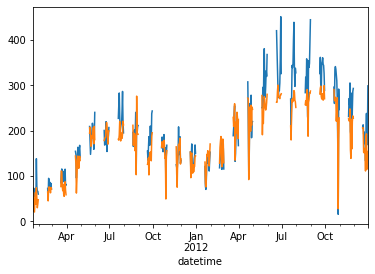

In [506]:
y_pred_test["y_pred_test"].resample("D").mean().plot()
y_pred_test["y_pred_rf"].resample("D").mean().plot()

### Combining both test and train datasets visually

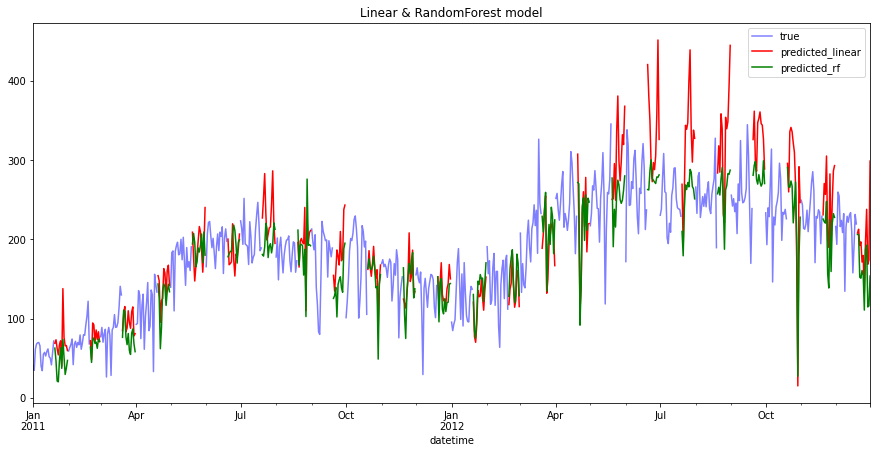

In [507]:
plt.figure(figsize=(15,7))

ax = df['count'].resample('D').mean().plot(c='b', alpha=0.5, label='true')
#ypred_log1_lp.resample('D').mean().plot(c='m', alpha=0.5, ax=ax, label='predicted_linearpoly')
y_pred_test['y_pred_test'].resample('D').mean().plot(c='r', ax=ax, label = 'predicted_linear')
y_pred_test['y_pred_rf'].resample('D').mean().plot(c='g', ax=ax, label = 'predicted_rf')

ax.set_title('Linear & RandomForest model')
plt.legend()

plt.savefig("Linear_RF_Model_true_predtest")

In [508]:
y_pred_test

y_pred_test   y_pred_rf
datetime                                    
2011-01-20 00:00:00     5.316671   11.628622
2011-01-20 01:00:00     6.173184    5.345479
2011-01-20 02:00:00     6.298940    3.799756
2011-01-20 03:00:00     6.431332    3.142080
2011-01-20 04:00:00     7.699728    2.655203
...                          ...         ...
2012-12-31 19:00:00   828.243885  268.281163
2012-12-31 20:00:00   195.881403  187.435260
2012-12-31 21:00:00   192.599888  135.870782
2012-12-31 22:00:00   163.410244  104.295693
2012-12-31 23:00:00   137.152308   58.203470

[6493 rows x 2 columns]

In [509]:
Submission_df_lr = pd.DataFrame({"count" : y_pred_test["y_pred_test"].round()})
Submission_df_lr
Submission_df_rfr = pd.DataFrame({"count" : y_pred_test["y_pred_rf"].round()})

In [510]:
Submission_df_lr.to_csv("./redone_lr_submission.csv", index=True)
Submission_df_rfr.to_csv("./redone_rfr_submission.csv", index=True)

### kaggle score (RMSLE)

- linear regression model : 0.747
- random forest regression model : 0.439